In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import math
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/My Drive/webeet/day4/sat-results.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Inspecting the data

In [2]:
df.head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,SAT Critical Readng Avg. Score,internal_school_id,contact_extension,pct_students_tested,academic_tier_rating
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363,355,218160,x345,78%,2.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366,383,268547,x234,NaN,3.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370,377,236446,x123,NaN,3.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359,414,427826,x123,92%,4.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384,390,672714,x123,92%,2.0


In [3]:
df.describe()

,internal_school_id,academic_tier_rating
count,493.000000,402.000000
mean,562172.943205,2.564677
std,262138.627055,1.126443
min,101855.000000,1.000000
25%,332013.000000,2.000000
50%,587220.000000,3.000000
75%,782993.000000,4.000000
max,999398.000000,4.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   DBN                              493 non-null    object 
 1   SCHOOL NAME                      493 non-null    object 
 2   Num of SAT Test Takers           493 non-null    object 
 3   SAT Critical Reading Avg. Score  493 non-null    object 
 4   SAT Math Avg. Score              493 non-null    object 
 5   SAT Writing Avg. Score           493 non-null    object 
 6   SAT Critical Readng Avg. Score   493 non-null    object 
 7   internal_school_id               493 non-null    int64  
 8   contact_extension                388 non-null    object 
 9   pct_students_tested              376 non-null    object 
 10  academic_tier_rating             402 non-null    float64
dtypes: float64(1), int64(1), object(9)
memory usage: 42.5+ KB


In [5]:
#this is a duplicate column with a typo
df.drop('SAT Critical Readng Avg. Score', axis=1, inplace=True)

In [6]:
df.isnull().sum()

,0
DBN,0
SCHOOL NAME,0
Num of SAT Test Takers,0
SAT Critical Reading Avg. Score,0
SAT Math Avg. Score,0
SAT Writing Avg. Score,0
internal_school_id,0
contact_extension,105
pct_students_tested,117
academic_tier_rating,91


In [7]:
#Checking the critical columns
#Reading
print("=== SAT Critical Reading Avg. Score ===")
print(df["SAT Critical Reading Avg. Score"].describe(), "\n")

#Math
print("=== SAT Math Avg. Score ===")
print(df["SAT Math Avg. Score"].describe(), "\n")

#Writing
print("=== SAT Writing Avg. Score ===")
print(df["SAT Writing Avg. Score"].describe())
#there are lots of rows with a "s". This needs to be cleaned. Before I will check out the distribution

=== SAT Critical Reading Avg. Score ===
count     493
unique    164
top         s
freq       58
Name: SAT Critical Reading Avg. Score, dtype: object 

=== SAT Math Avg. Score ===
count     493
unique    177
top         s
freq       58
Name: SAT Math Avg. Score, dtype: object 

=== SAT Writing Avg. Score ===
count     493
unique    163
top         s
freq       58
Name: SAT Writing Avg. Score, dtype: object


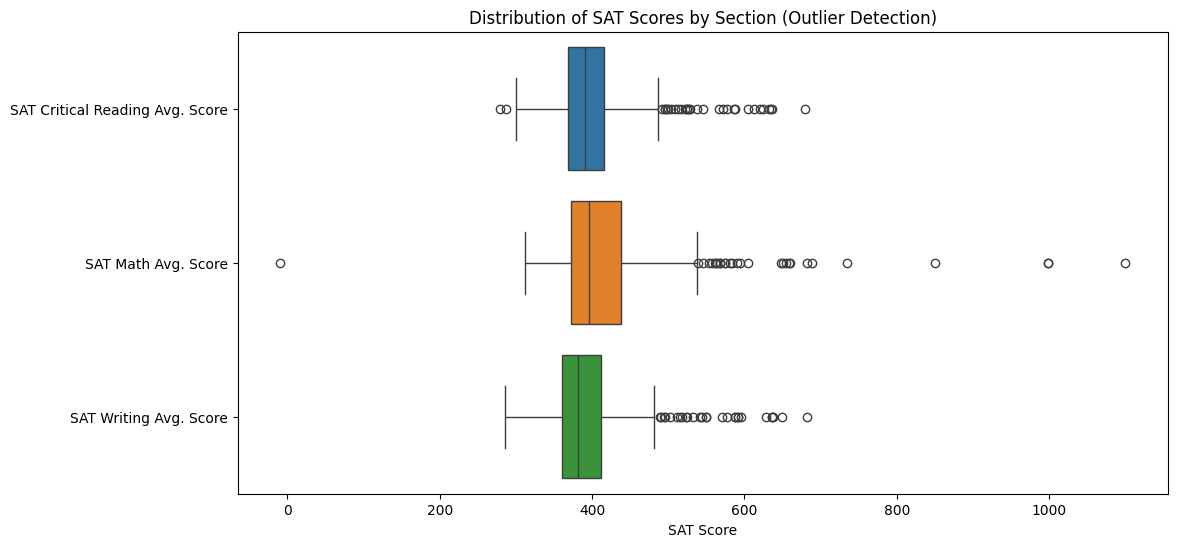

In [8]:
# Columns with SAT scores
score_cols = [
    "SAT Critical Reading Avg. Score",
    "SAT Math Avg. Score",
    "SAT Writing Avg. Score"
]

# Convert to numeric, coerce invalid entries (like "s") to NaN
df_scores = df[score_cols].apply(pd.to_numeric, errors="coerce")

# Boxplot visualization
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_scores, orient="h")
plt.title("Distribution of SAT Scores by Section (Outlier Detection)")
plt.xlabel("SAT Score")
plt.show()
#the valid range of scores is 200-800, so this needs to be taken care of

In [9]:
#Columns to clean from the "s" and to fix the valid range
# Replace "s" and other non-numeric values with NaN, then convert to numeric
df[score_cols] = df[score_cols].replace("s", pd.NA).apply(pd.to_numeric, errors="coerce")

#valid SAT score range (200–800), set outliers to NaN
for col in score_cols:
    df.loc[~df[col].between(200, 800), col] = pd.NA

# Check results
print(df[score_cols].describe())


       SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
count                       435.000000           430.000000   
mean                        400.712644           413.341860   
std                          56.056774            64.141429   
min                         279.000000           312.000000   
25%                         368.000000           372.000000   
50%                         391.000000           395.000000   
75%                         416.000000           437.000000   
max                         679.000000           735.000000   

       SAT Writing Avg. Score  
count              435.000000  
mean               393.712644  
std                 57.870447  
min                286.000000  
25%                360.000000  
50%                382.000000  
75%                411.000000  
max                682.000000  


In [10]:
df.isna().sum()

,0
DBN,0
SCHOOL NAME,0
Num of SAT Test Takers,0
SAT Critical Reading Avg. Score,58
SAT Math Avg. Score,63
SAT Writing Avg. Score,58
internal_school_id,0
contact_extension,105
pct_students_tested,117
academic_tier_rating,91


In [11]:
# Show rows where at least one SAT score is NaN
df[df[[
    "SAT Critical Reading Avg. Score",
    "SAT Math Avg. Score",
    "SAT Writing Avg. Score"
]].isna().any(axis=1)]
#this shows that the NUM of SAT Test Takers is also "s"

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,internal_school_id,contact_extension,pct_students_tested,academic_tier_rating
22,02M392,MANHATTAN BUSINESS ACADEMY,s,NaN,NaN,NaN,501072,NaN,85%,NaN
23,02M393,BUSINESS OF SPORTS SCHOOL,s,NaN,NaN,NaN,143204,x234,NaN,2.0
25,02M399,THE HIGH SCHOOL FOR LANGUAGE AND DIPLOMACY,s,NaN,NaN,NaN,371710,x123,85%,NaN
38,02M427,MANHATTAN ACADEMY FOR ARTS & LANGUAGE,s,NaN,NaN,NaN,521180,x234,NaN,4.0
40,02M437,HUDSON HIGH SCHOOL OF LEARNING TECHNOLOGIES,s,NaN,NaN,NaN,254767,x345,NaN,2.0
...,...,...,...,...,...,...,...,...,...,...
472,75R025,SOUTH RICHMOND HIGH SCHOOL I.S./P.S. 25,s,NaN,NaN,NaN,789985,NaN,78%,1.0
473,75X012,P.S. X012 LEWIS AND CLARK SCHOOL,s,NaN,NaN,NaN,733698,x234,92%,1.0
474,75X754,J. M. RAPPORT SCHOOL CAREER DEVELOPMENT,s,NaN,NaN,NaN,976034,x345,NaN,4.0
475,79M645,SCHOOL FOR COOPERATIVE TECHNICAL EDUCATION,s,NaN,NaN,NaN,556924,x123,85%,1.0


In [12]:
# Drop rows where any SAT score is NaN
df = df.dropna(subset=[
    "SAT Critical Reading Avg. Score",
    "SAT Math Avg. Score",
    "SAT Writing Avg. Score"
])

In [13]:
# Drop rows where "Num of SAT Test Takers" has the value "s" directly
df = df[df["Num of SAT Test Takers"] != "s"].copy()


In [14]:
df.duplicated().sum()

np.int64(14)

In [15]:
df.drop_duplicates(inplace=True)

In [16]:
df.isna().sum()

,0
DBN,0
SCHOOL NAME,0
Num of SAT Test Takers,0
SAT Critical Reading Avg. Score,0
SAT Math Avg. Score,0
SAT Writing Avg. Score,0
internal_school_id,0
contact_extension,85
pct_students_tested,103
academic_tier_rating,67


In [17]:
import re

def snake_case(s: str) -> str:
    s = s.strip()
    s = re.sub(r"[^\w\s]+", " ", s)   # Sonderzeichen raus
    s = re.sub(r"\s+", "_", s)        # Whitespace → Unterstrich
    return s.lower()

# Column-Namen normalisieren
df.columns = [snake_case(col) for col in df.columns]

df.columns


Index(['dbn', 'school_name', 'num_of_sat_test_takers',
       'sat_critical_reading_avg_score', 'sat_math_avg_score',
       'sat_writing_avg_score', 'internal_school_id', 'contact_extension',
       'pct_students_tested', 'academic_tier_rating'],
      dtype='object')

In [18]:
df.head()

,dbn,school_name,num_of_sat_test_takers,sat_critical_reading_avg_score,sat_math_avg_score,sat_writing_avg_score,internal_school_id,contact_extension,pct_students_tested,academic_tier_rating
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,218160,x345,78%,2.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,268547,x234,NaN,3.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377.0,402.0,370.0,236446,x123,NaN,3.0
3,01M458,FORSYTH SATELLITE ACADEMY,7,414.0,401.0,359.0,427826,x123,92%,4.0
4,01M509,MARTA VALLE HIGH SCHOOL,44,390.0,433.0,384.0,672714,x123,92%,2.0


In [19]:
#relevant columns for the schema
final_cols = [
    "dbn",
    "school_name",
    "internal_school_id",
    "num_of_sat_test_takers",
    "sat_critical_reading_avg_score",
    "sat_math_avg_score",
    "sat_writing_avg_score",
    "academic_tier_rating"
]

df_final = df[final_cols].copy()
df_final.head()


,dbn,school_name,internal_school_id,num_of_sat_test_takers,sat_critical_reading_avg_score,sat_math_avg_score,sat_writing_avg_score,academic_tier_rating
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,218160,29,355.0,404.0,363.0,2.0
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,268547,91,383.0,423.0,366.0,3.0
2,01M450,EAST SIDE COMMUNITY SCHOOL,236446,70,377.0,402.0,370.0,3.0
3,01M458,FORSYTH SATELLITE ACADEMY,427826,7,414.0,401.0,359.0,4.0
4,01M509,MARTA VALLE HIGH SCHOOL,672714,44,390.0,433.0,384.0,2.0


In [20]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 416 entries, 0 to 477
Data columns (total 8 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   dbn                             416 non-null    object 
 1   school_name                     416 non-null    object 
 2   internal_school_id              416 non-null    int64  
 3   num_of_sat_test_takers          416 non-null    object 
 4   sat_critical_reading_avg_score  416 non-null    float64
 5   sat_math_avg_score              416 non-null    float64
 6   sat_writing_avg_score           416 non-null    float64
 7   academic_tier_rating            349 non-null    float64
dtypes: float64(4), int64(1), object(3)
memory usage: 29.2+ KB


#Export to CSV

In [21]:
out_path = "normalized_sat_results.csv"
df.to_csv(out_path, index=False)